### Camera Simulator

This is a first stab at a camera simulator using python. ChatGPT was used for reference and Q&A.

Import necessary libraries first

In [2]:
!pip install imageio
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.8 MB/s eta 0:00:0000:010:01m
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.1.0
    Uninstalling Pillow-10.1.0:
      Successfully uninstalled Pillow-10.1.0


Define the parameters of the images and/or sensor that will be used below

In [3]:
image_width = 2048
image_height = 2048
exposure_time = 10  # Exposure time in seconds (?)
scene_type = "Simple SpecRad" # choose scene option
mean_luminance = 100 # cd/m2. Used only for scene 3

In [4]:
# Define Noise Functions

# Simulate photon shot noise
def simulate_photon_noise(image, exposure_time):
    """
    Simulates photon shot noise. This noise is inherent to the randomness of photon arrivals.
    :param image: The initial image data (electron counts).
    :return: Simulated image data with added photon noise.
    """
    scaled_image = image * exposure_time
    poisson_noise = np.random.poisson(scaled_image) / exposure_time
    return np.clip(poisson_noise, 0, 255)  # Clip values to [0, 255]

# Simulate read noise
def simulate_read_noise(image, read_noise_std):
    """
    Simulates read noise. This noise is introduced during the readout process of the sensor.
    :param image: The image data (electron counts) before read noise.
    :param read_noise_std: Standard deviation of the read noise.
    :return: Simulated image data with added read noise.
    """
    noisy_image = image + np.random.normal(0, read_noise_std, image.shape)
    return np.clip(noisy_image, 0, 255)  # Clip values to [0, 255]

# Simulate dark current noise
def simulate_dark_current(image, dark_current_rate, exposure_time):
    """
    Simulates dark current noise. Dark current is generated by the sensor even in the absence of light.
    :param image: The image data (electron counts) before dark current noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :param exposure_time: Exposure time in seconds.
    :return: Simulated image data with added dark current noise.
    """
    dark_noise = np.random.poisson(dark_current_rate * exposure_time, image.shape)
    noisy_image = image + dark_noise
    return np.clip(noisy_image, 0, 255)  # Clip values to [0, 255]

In [5]:
# Simulate CMOS camera

def simulate_cmos_camera(scene, exposure_time, read_noise_std, dark_current_rate):
    """
    Simulates the behavior of a CMOS camera sensor.
    :param scene: The input scene (e.g., a grayscale image).
    :param exposure_time: Exposure time in seconds.
    :param read_noise_std: Standard deviation of read noise.
    :param dark_current_rate: Dark current rate in electrons per second per pixel.
    :return: Simulated camera sensor output with photon noise, read noise, and dark current noise.
    """
    sensor_response = scene * exposure_time  # Apply exposure time
    sensor_response = simulate_photon_noise(sensor_response, exposure_time)  # Simulate photon shot noise
    sensor_response = simulate_read_noise(sensor_response, read_noise_std)  # Simulate read noise
    sensor_response = simulate_dark_current(sensor_response, dark_current_rate, exposure_time)  # Simulate dark current
    return sensor_response

In [6]:
# Scene simulation

if scene_type == '2D Gauss':
    # Create a structured scene with a 2D Gaussian distribution
    x, y = np.meshgrid(np.linspace(0, 1, image_width), np.linspace(0, 1, image_height))
    center_x, center_y = 0.5, 0.5  # Center of the Gaussian distribution
    std_x, std_y = 0.2, 0.2  # Standard deviation for the Gaussian distribution
    scene = np.exp(-((x - center_x) ** 2 / (2 * std_x ** 2) + (y - center_y) ** 2 / (2 * std_y ** 2)))

elif scene_type == "Simple SpecRad":
    # Wavelengths (in nanometers)
    wavelengths = np.linspace(400, 700, image_width)  # Adjust the range as needed

    # Create a spectral radiance distribution for the scene
    spectral_radiance = np.zeros((image_height, image_width))

    # Define a radiance pattern across wavelengths (e.g., a Gaussian distribution)
    # Adjust this pattern as needed to match your scene
    for i, wavelength in enumerate(wavelengths):
        spectral_radiance[:, i] = np.exp(-((wavelength - 550) ** 2 / (2 * 30 ** 2)))

    # Normalize the spectral radiance to your desired units
    # For this example, let's assume an arbitrary normalization factor
    scene = spectral_radiance #* 1e15  # Adjust as needed

elif scene_type == "Macbeth":
    # Define the spectral reflectance values for the Macbeth Color Checker
    # These values are typically available in standard data files
    # For simplicity, I'll use some example reflectance values
    reflectance_data = np.array([
        [0.02, 0.04, 0.06, 0.08, 0.10, 0.12],
        [0.14, 0.16, 0.18, 0.20, 0.22, 0.24],
        [0.26, 0.28, 0.30, 0.32, 0.34, 0.36],
        [0.38, 0.40, 0.42, 0.44, 0.46, 0.48]
    ])

# Define the spectral distribution of the D65 illuminant (in this case, a simplified version)
    wavelengths = np.linspace(380, 730, reflectance_data.shape[1])  # Wavelength range (nm)
    d65_illuminant = np.array([
        [94.81, 104.80, 105.97, 96.16, 113.45, 125.40],
        [132.10, 134.19, 131.43, 123.91, 113.42, 109.83],
        [107.21, 104.87, 103.17, 101.48, 100.00, 98.93],
        [98.05, 97.33, 96.73, 96.19, 95.70, 95.22]
    ])

    # Calculate the spectral radiance of the scene using the reflectance data and illuminant
    spectral_radiance = reflectance_data * d65_illuminant

    # Create interpolation functions for wavelength and reflectance
    interp_wavelength = RectBivariateSpline(np.arange(spectral_radiance.shape[0]), np.arange(spectral_radiance.shape[1]), wavelengths)
    interp_reflectance = RectBivariateSpline(np.arange(spectral_radiance.shape[0]), np.arange(spectral_radiance.shape[1]), reflectance_data)

    # Define the new dimensions
    x_new = np.linspace(0, spectral_radiance.shape[0] - 1, image_height)
    y_new = np.linspace(0, spectral_radiance.shape[1] - 1, image_width)

    # Perform the interpolation
    wavelengths_new = interp_wavelength(x_new, y_new)
    reflectance_new = interp_reflectance(x_new, y_new)

    # Calculate the spectral radiance for the new dimensions
    spectral_radiance_new = reflectance_new * wavelengths_new

    # Scale the spectral radiance to achieve the desired mean luminance
    scale_factor = mean_luminance / np.mean(spectral_radiance_new)
    scene = spectral_radiance_new * scale_factor

else:
    print("Invalid scene type provided") 

In [7]:
# Simulate camera response and display output

# Simulate CMOS camera response with proper scaling
camera_output = simulate_cmos_camera(scene, exposure_time=exposure_time, read_noise_std=0.0005, dark_current_rate=0.001)

# Linearly rescale the camera output to the [0, 255] range
min_value = np.min(camera_output)
max_value = np.max(camera_output)
camera_output = 255 * (camera_output - min_value) / (max_value - min_value)


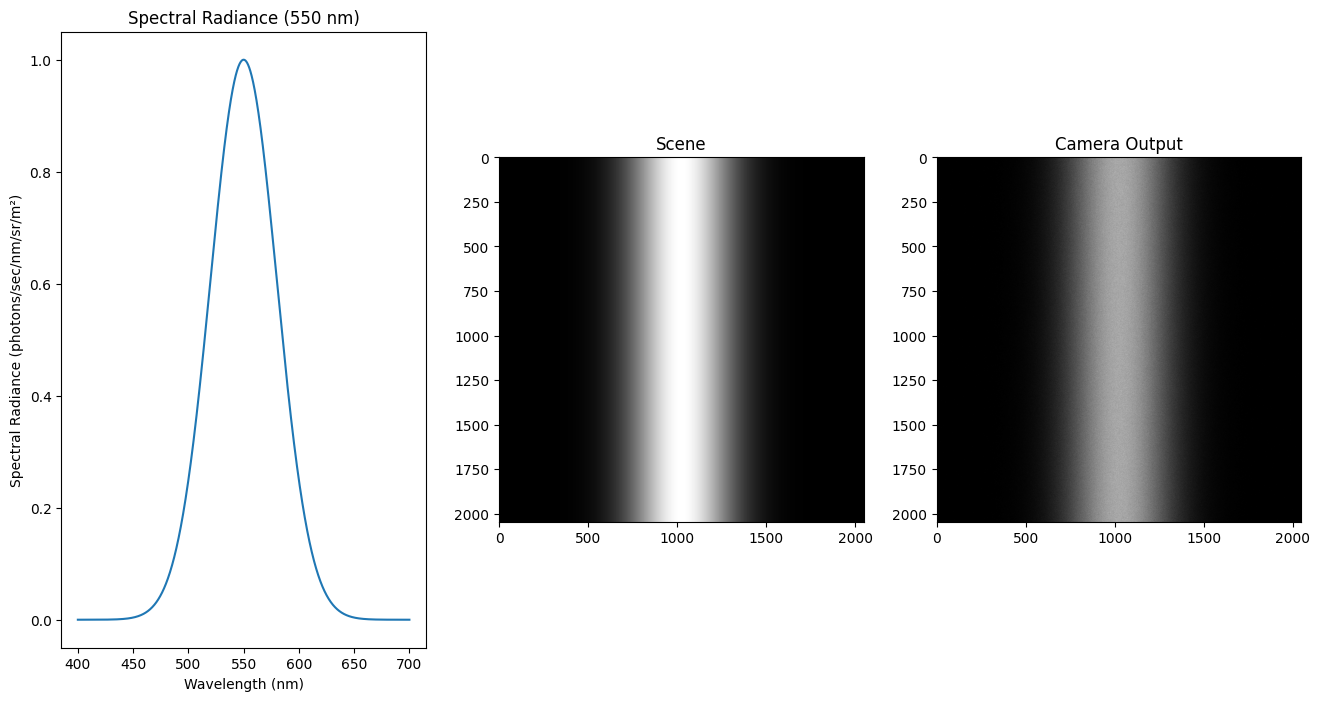

0.2505402916810058 41.92911529508138


In [8]:
# Display the scene and camera output (Only run if Scene 1 is used)
if scene_type == '2D Gauss':
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

elif scene_type == "Simple SpecRad":
    # Display the scene and camera output (Only run if Scene 2 is used)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.title("Spectral Radiance (550 nm)")
    plt.plot(wavelengths, scene[image_height // 2, :])
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (photons/sec/nm/sr/m²)")

    #plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 2)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

elif scene_type == "Macbeth":
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Spectral Radiance (550 nm)")
    plt.plot(wavelengths, scene[1, :])  # Display the radiance of the second color patch
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Spectral Radiance (photons/sec/nm/sr/m²)")

    #plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 2)
    plt.title("Scene")
    plt.imshow(scene, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.title("Camera Output")
    plt.imshow(camera_output, cmap='gray')

else:
    print("Invalid scene type provided") 

plt.show()

scene_mean = np.mean(scene)
camera_output_mean = np.mean(camera_output)
print(scene_mean, camera_output_mean)

### Trying EMVA Camera Simulator (similar to Algolux)

1. Import sample png image

/var/folders/jz/7t_94n991b13sn849gsrqnx00000gp/T/ipykernel_98896/2277655595.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("macbeth.png")


(753, 1132, 4)

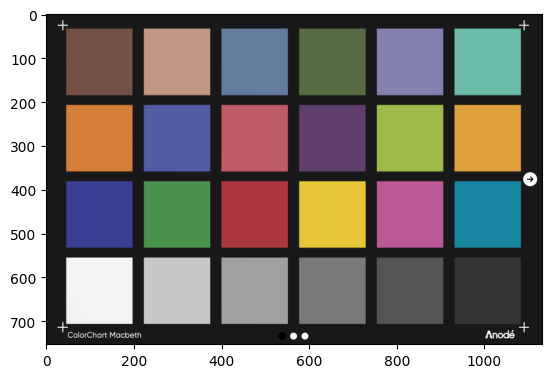

In [9]:
img = imageio.imread("macbeth.png")
h, w = img.shape[:-1]
plt.imshow(img)
img.shape

2. Simulate the radiance spectrum of the image

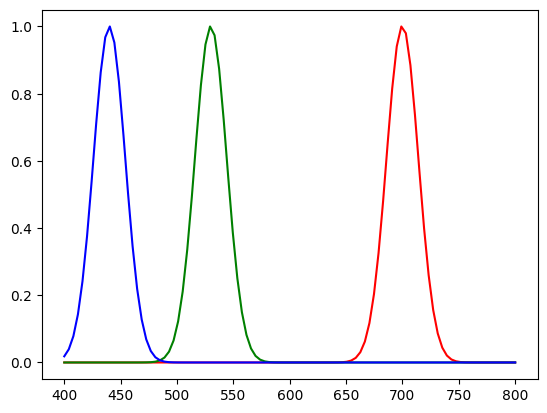

In [10]:
# Peak Wavelength values for R, G, and B

r,g,b = (700,530,440)

# Consider wavelengths from 400 nm to 800 nm

dom = np.linspace(400, 800, 100)

# Build nromal distributions centered around each peak wavelength

sig = 200
red = 1/(2*np.pi*sig) * np.exp(-((dom-r)**2)/(2*sig))
green = 1/(2*np.pi*sig) * np.exp(-((dom-g)**2)/(2*sig))
blue = 1/(2*np.pi*sig) * np.exp(-((dom-b)**2)/(2*sig))

# Normalise values

red /= np.max(red)
green /= np.max(green)
blue /= np.max(blue)

#Multiply each channel of each pixel with its corresponding 

spectrum = np.einsum('ij,k->ijk', img[:, :, 0].astype(float), red) + \
            np.einsum('ij,k->ijk', img[:, :, 1].astype(float), green) + \
            np.einsum('ij,k->ijk', img[:, :, 2].astype(float), blue)

plt.plot(dom, red, 'r')
plt.plot(dom, green, 'g')
plt.plot(dom, blue, 'b')



3. Transform the pixels

pixel (1,1): , r: 24, g: 24, b: 24


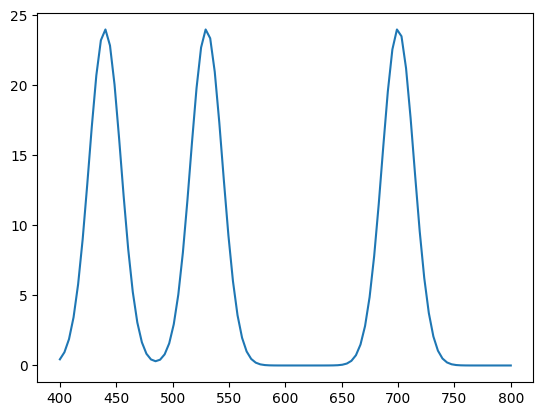

In [11]:
# Visualise result of the transformation

print('pixel (1,1): , r: %s, g: %s, b: %s' % (img[1,1,0], img[1,1,1], img[1,1,2]))
plt.plot(dom,spectrum[1,1,:])

4. QE

Will need to clone the emva1288 python module into my machine

In [14]:
print(h,w)

753 1132


In [18]:
from emva1288.camera import Camera
from emva1288.camera.routines import Qe, get_bayer_filter

In [ ]:
# Create a Bayer filter
filt = get_bayer_filter(450, 550, 550, 700, w, h, dom)

# Create QE object based on filter and image size
qe = Qe(filter = filt, width = w, height = h)

# Initialise camera
cam = Camera(qe = qe, width = w, height = h)

plt.plot(dom, qe.qe[0,0], 'b')
plt.plot(dom, qe.qe[1,0], 'g')
plt.plot(dom, qe.qe[1,1], 'r')